In [2]:
import os
import time
from basic_parameters import basic_params
from process import processing_and_save
timer = time.time()
os.system("mpiexec -n 6 python3 base_model.py")
print("Simulation is finished!")
print(time.time() - timer)

file = basic_params["file_results"]
processing_and_save(file)


Simulation is finished!
0.009871482849121094


/usr/local/lib/python3.8/dist-packages/elephant/pandas_bridge.py:21: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  warnings.warn("pandas_bridge module will be removed in Elephant v0.8.x",


KeyError: "Unable to open object (object 'time' doesn't exist)"

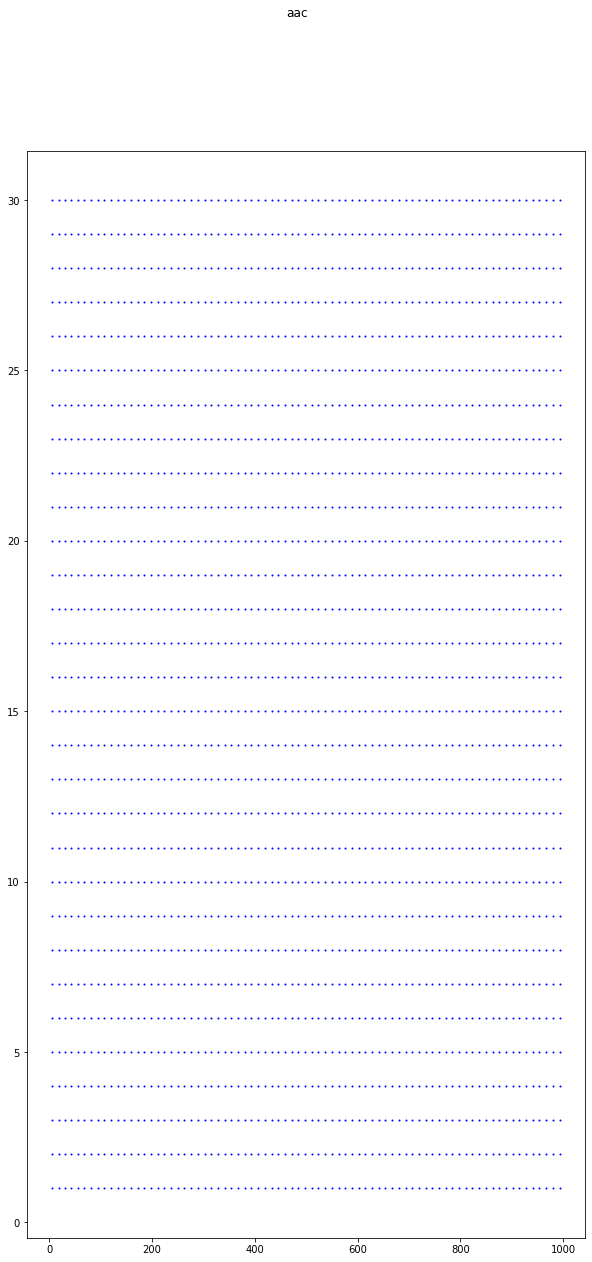

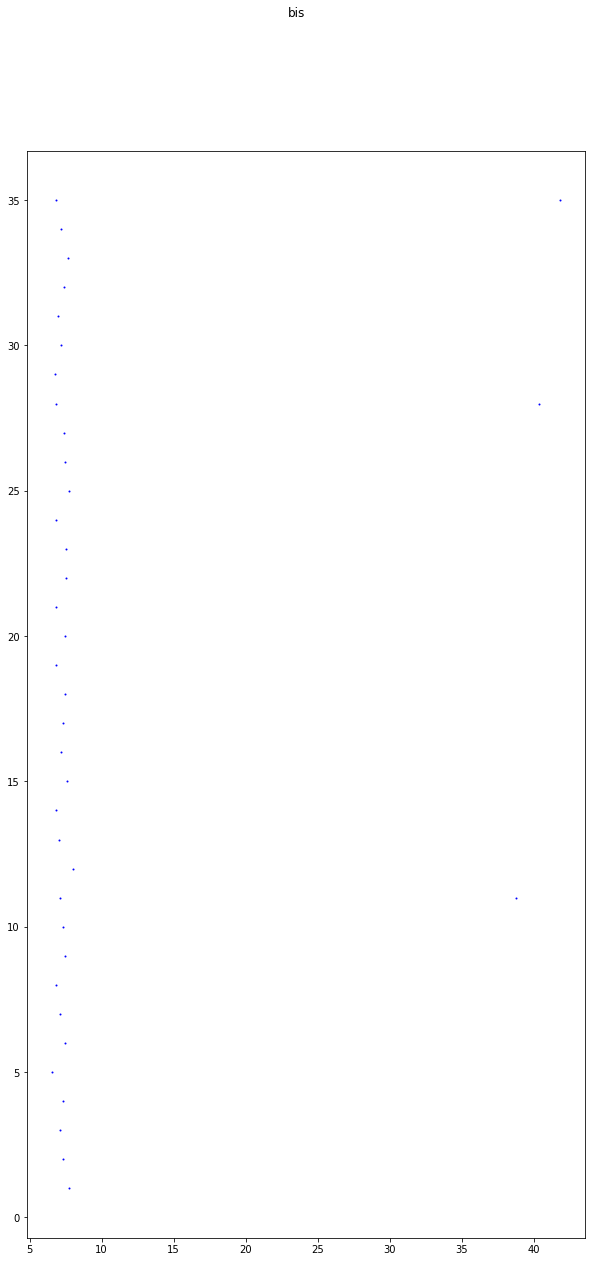

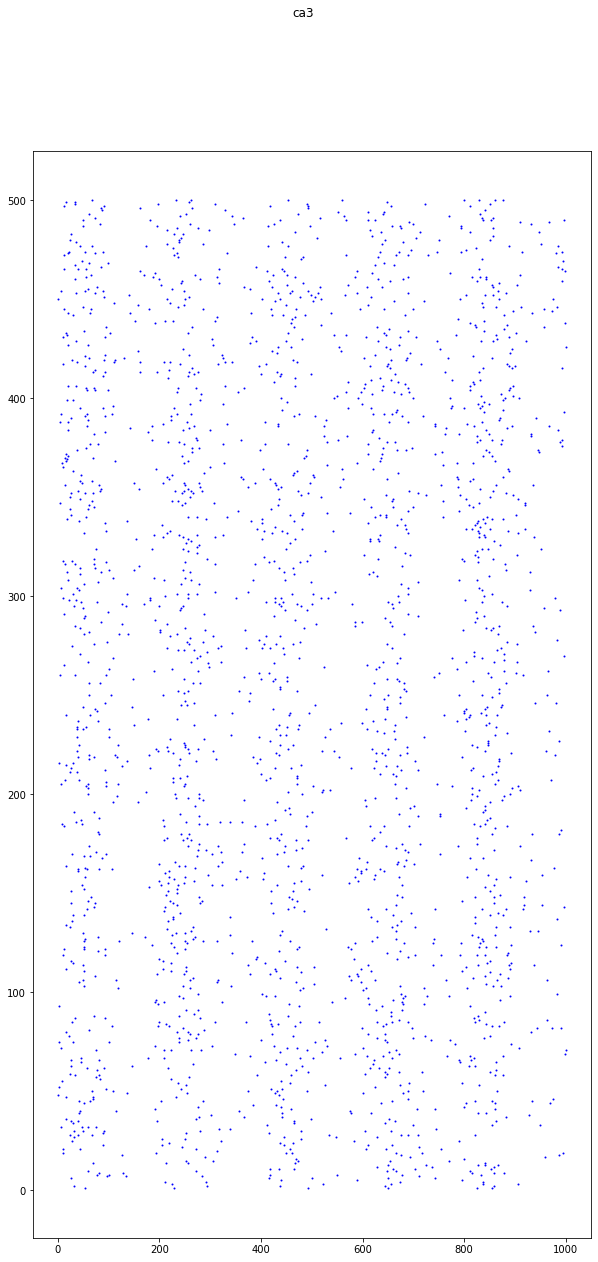

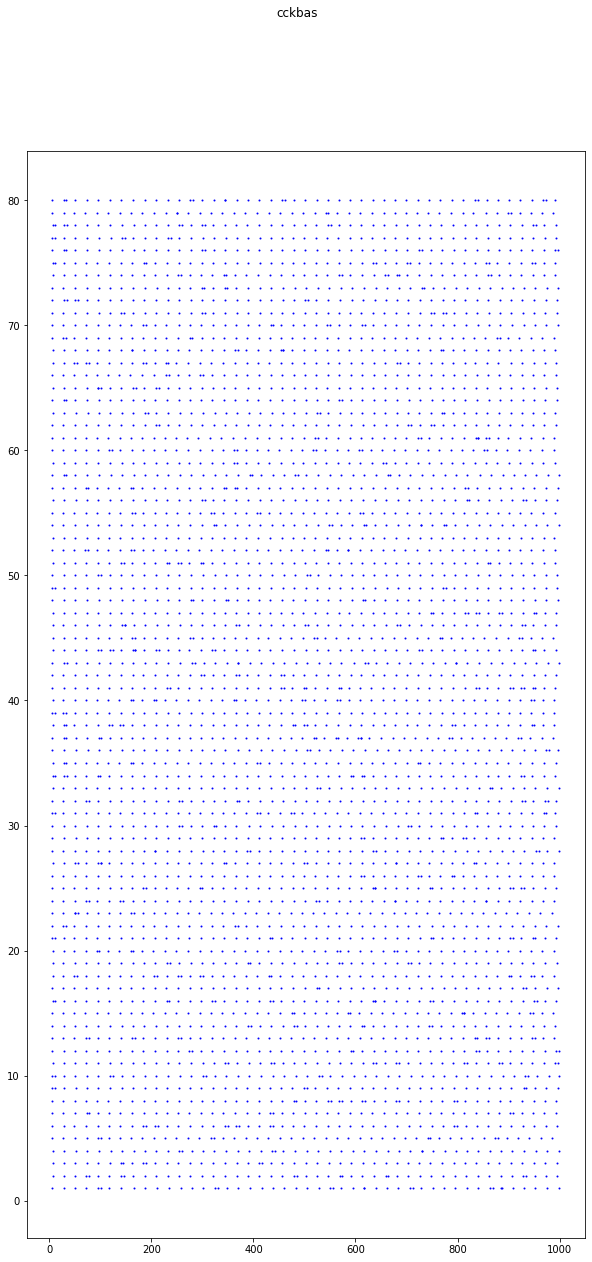

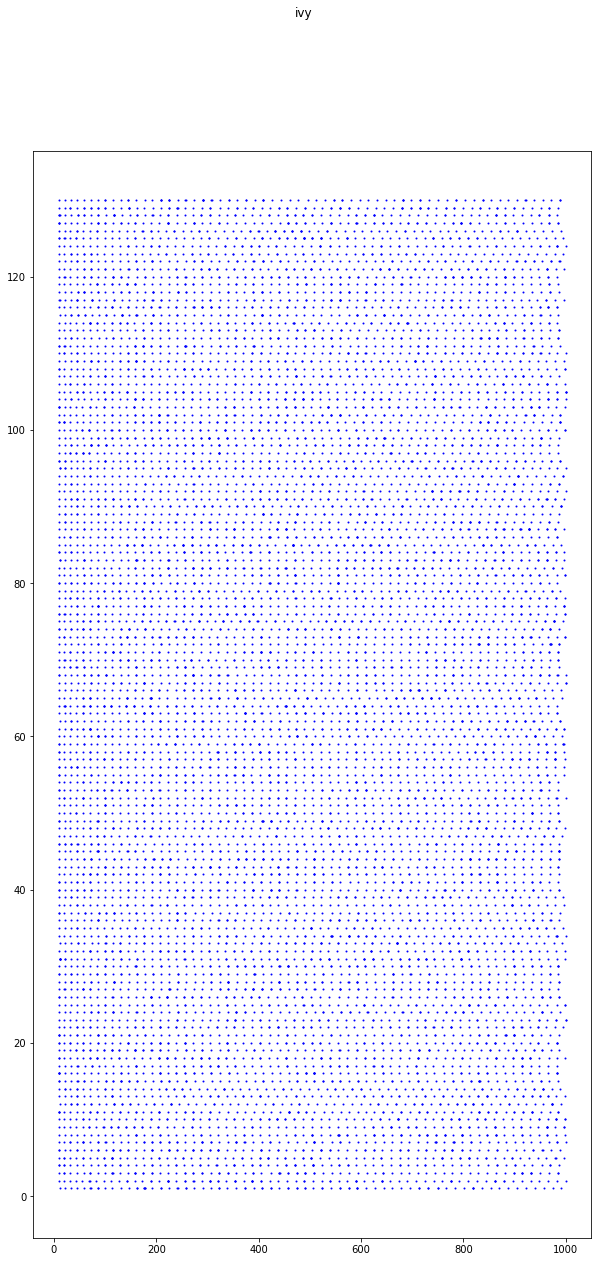

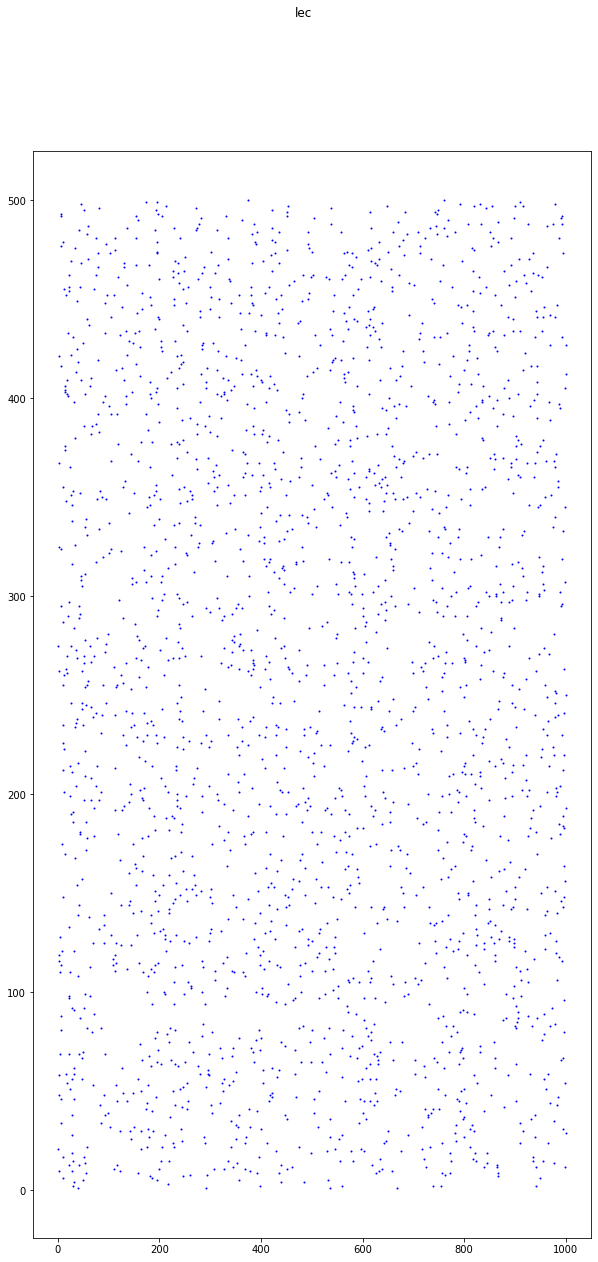

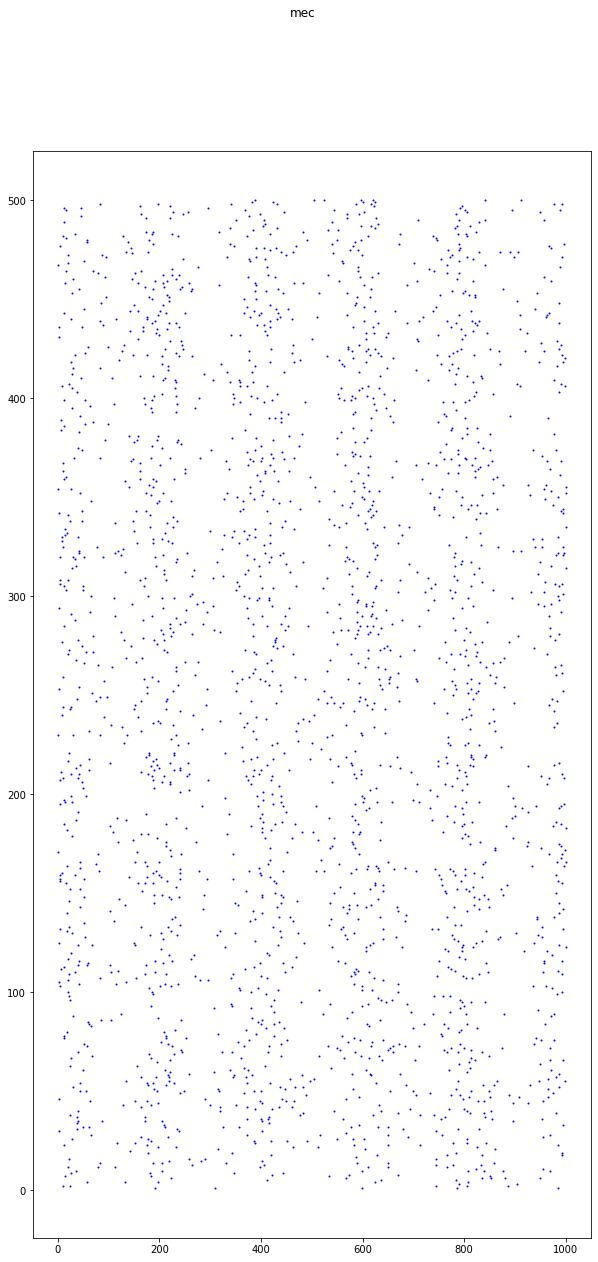

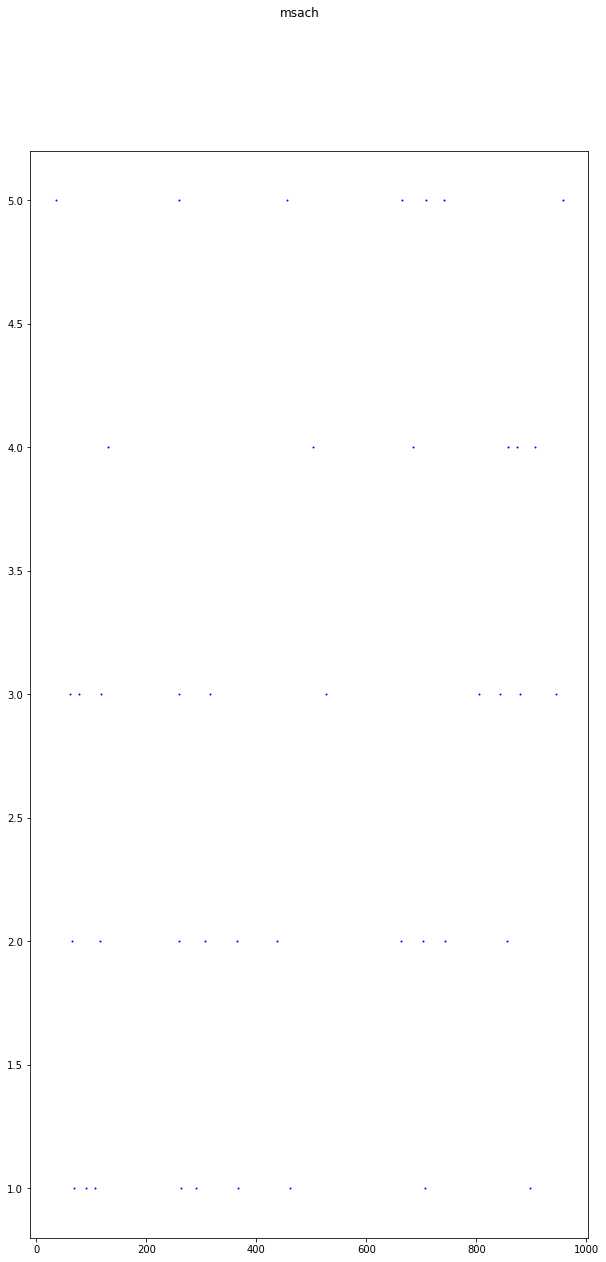

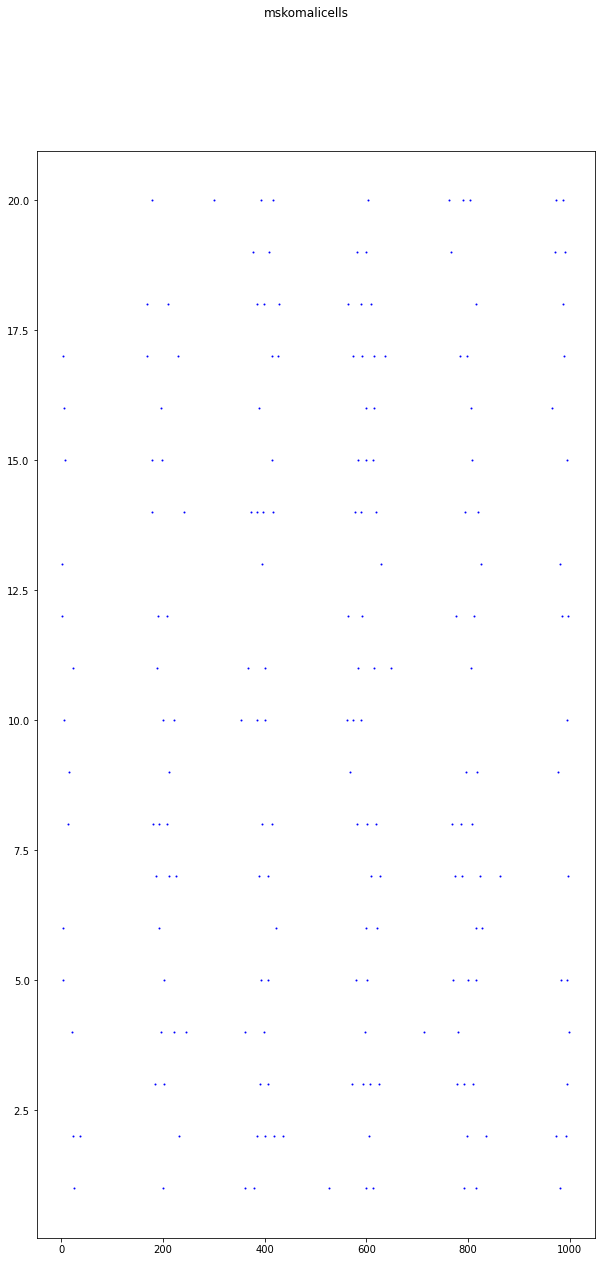

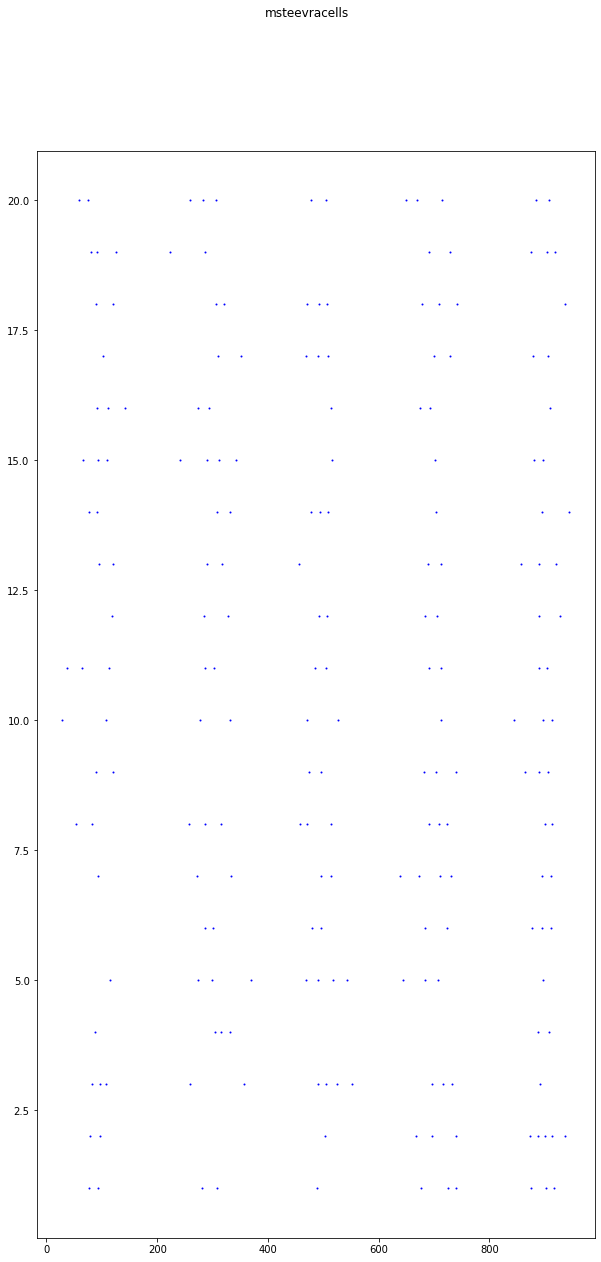

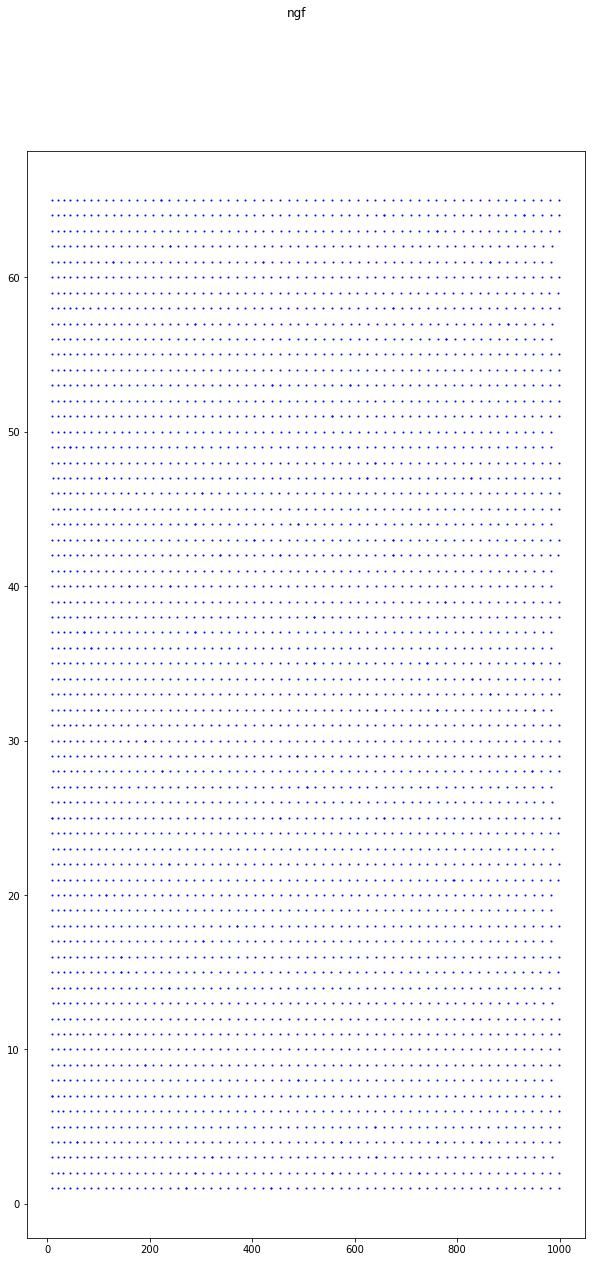

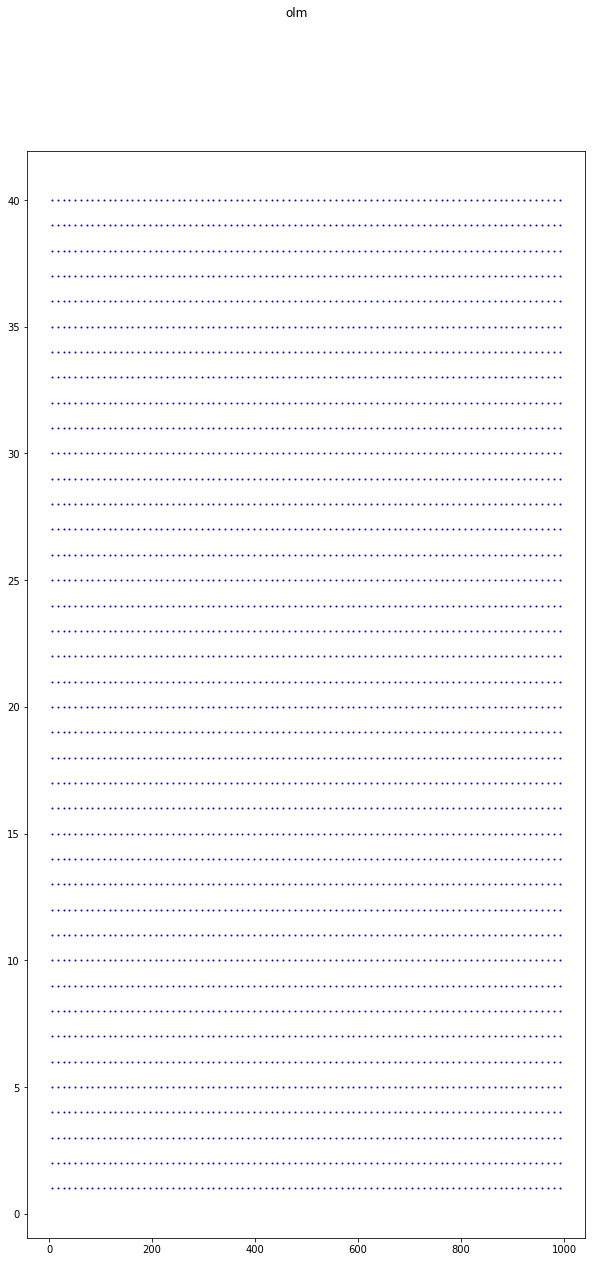

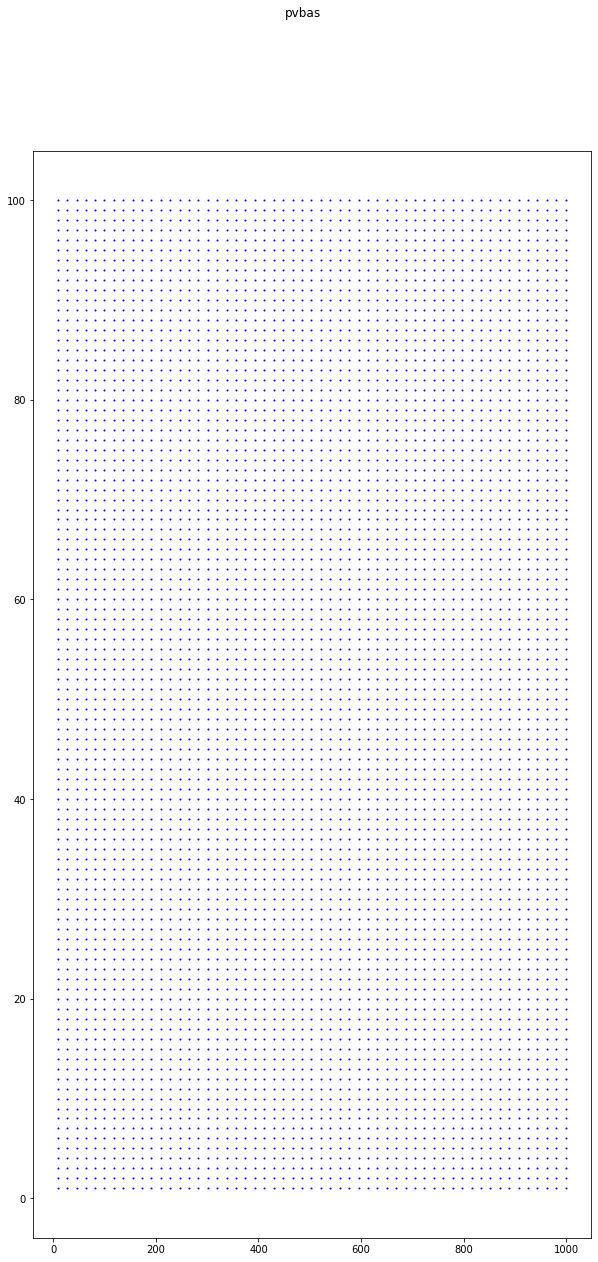

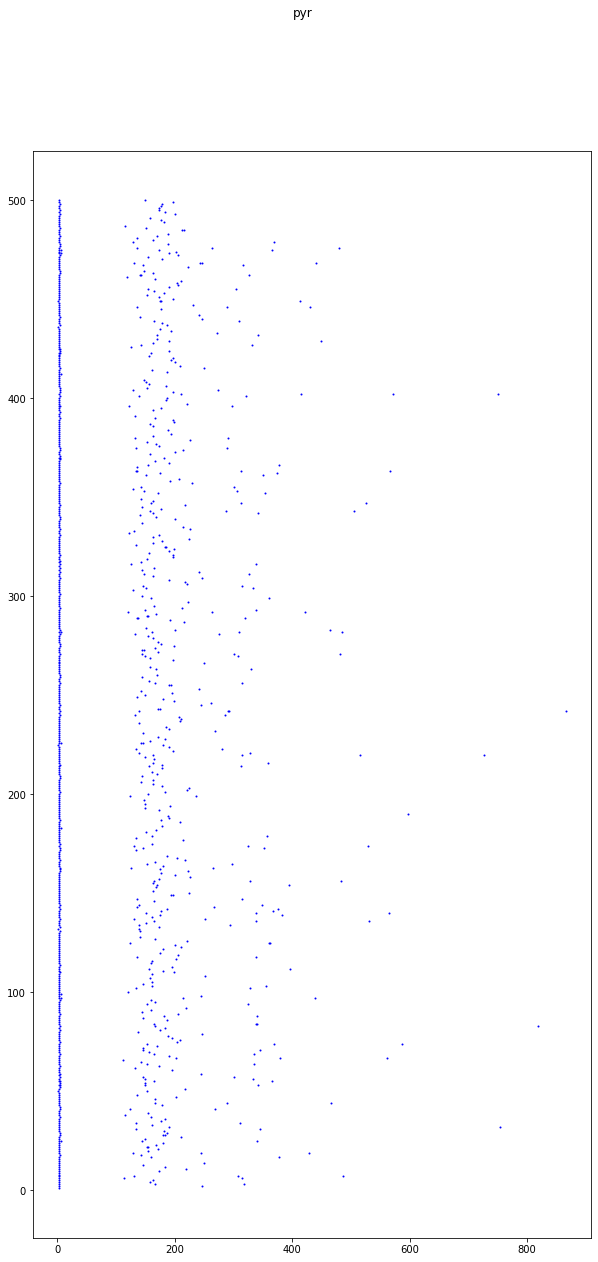

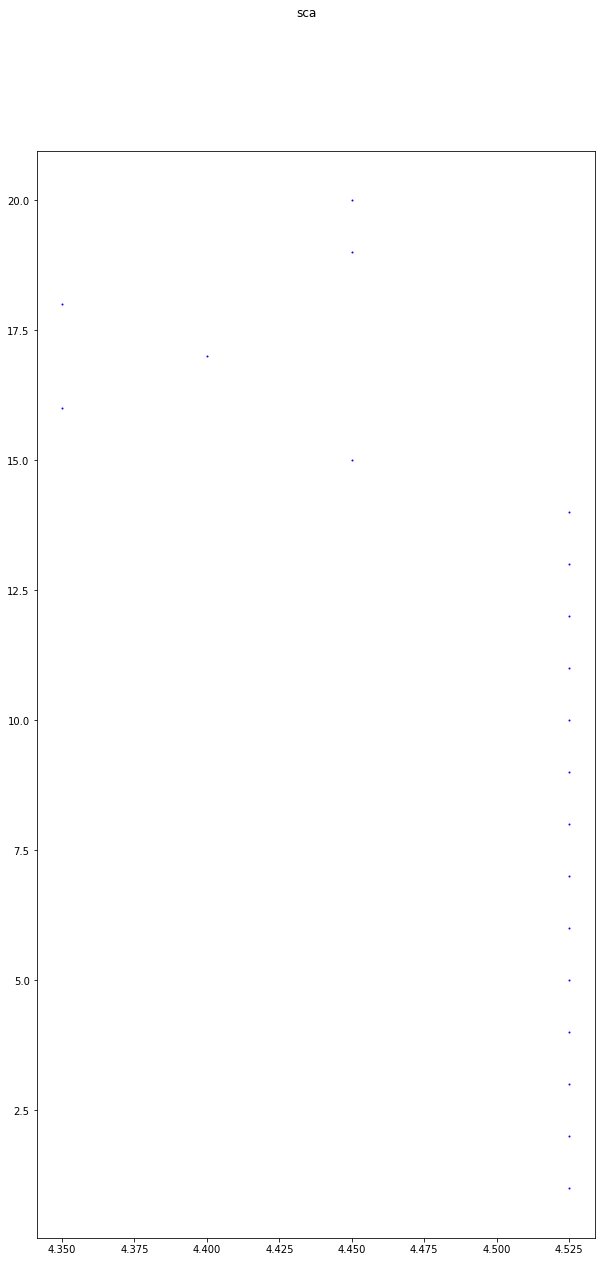

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,20)
from basic_parameters import basic_params
import plot_result as my_plot

file = basic_params["file_results"]
# my_plot.plot_v(file)

my_plot.plot_spike_raster(file)
# my_plot.plot_lfp(path)
# splot_phase_disrtibution(path)







In [2]:
from process import processing_and_save
from basic_parameters import basic_params

file = basic_params["file_results"]
processing_and_save(file)

/usr/local/lib/python3.8/dist-packages/elephant/pandas_bridge.py:21: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  warnings.warn("pandas_bridge module will be removed in Elephant v0.8.x",
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


IndexError: index 40000 is out of bounds for axis 0 with size 40000